<a href="https://colab.research.google.com/github/09334677600f/Code-for-Chapter-4/blob/main/Random_Forest(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

print("شروع آماده‌سازی داده‌ها...\n")

شروع آماده‌سازی داده‌ها...



In [ ]:
df = pd.read_excel("final_file1 (2).xlsx")

In [ ]:
# حذف ستون‌های غیرضروری
columns_to_drop = [
    "ID", "Accident_ID", "تعداد تصادف",
    "تاریخ", "زمان تماس", "ساعت رسیدن به محل حادثه"
]
df = df.drop(columns=[c for c in columns_to_drop if c in df.columns])

# حذف ردیف‌های دارای NaN
df = df.dropna().reset_index(drop=True)
print(f"تعداد رکورد نهایی بعد از حذف NaN: {df.shape[0]}")  # باید حدود 22099 بشه

# ویژگی‌ها (X) و هدف (y) برای رگرسیون
X_cols = [
    "سن بیمار", "جنسیت", "زمان شب و روز",
    "نوع روز", "فصل", "ساعت اوج ترافیک"
]
X = df[X_cols].copy()

# هدف: فقط مدت زمان (زمان پاسخ اورژانس) - برای رگرسیون
y_time = df["مدت زمان"].astype(float)

print("تعداد رکوردهای هدف (مدت زمان):", len(y_time))


# پیش‌پردازش: مقیاس عددی + One-Hot برای دسته‌ای

categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز", "فصل", "ساعت اوج ترافیک"]
numeric_cols = ["سن بیمار"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

X_processed = preprocessor.fit_transform(X)

print(f"شکل داده‌های پردازش‌شده (X_processed): {X_processed.shape}")

# نام ویژگی‌ها برای اهمیت متغیرها
feature_names = (
    numeric_cols +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)
print("نام ویژگی‌های نهایی:")
print(feature_names)


# تقسیم داده به train و test

X_train, X_test, y_train, y_test_time = train_test_split(
    X_processed, y_time,
    test_size=0.2,
    random_state=42
)

In [ ]:

# بهینه‌سازی Random Forest Regressor با Optuna و 5-fold CV
# فقط دو ابرپارامتر: تعداد درخت‌ها و عمق

import gc
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

gc.collect()

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 100, step=5)
    max_depth = trial.suggest_int('max_depth', 1, 5)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            n_jobs=1,
            max_features='sqrt'
        )

        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        mae_scores.append(mean_absolute_error(y_val, pred))

        del model
        gc.collect()

    return np.mean(mae_scores)

print("شروع بهینه‌سازی Optuna برای Random Forest Regressor...\n")
study_reg = optuna.create_study(direction='minimize')
study_reg.optimize(objective, n_trials=40, show_progress_bar=True)

best_params_reg = study_reg.best_params
print("\nبهینه‌سازی تمام شد!")
print(f"بهترین MAE در CV: {study_reg.best_value:.3f} دقیقه")
print(f"بهترین ابرپارامترها: n_estimators={best_params_reg['n_estimators']}, max_depth={best_params_reg['max_depth']}")


[I 2026-01-07 20:16:18,907] A new study created in memory with name: no-name-b731bafd-9839-4cc4-97e2-0f5836398605


شروع بهینه‌سازی Optuna برای Random Forest Regressor...



Best trial: 0. Best value: 4.46597:   2%|█▏                                             | 1/40 [00:01<00:47,  1.22s/it]

[I 2026-01-07 20:16:20,130] Trial 0 finished with value: 4.4659686239715 and parameters: {'n_estimators': 90, 'max_depth': 1}. Best is trial 0 with value: 4.4659686239715.


Best trial: 1. Best value: 4.4192:   5%|██▍                                             | 2/40 [00:02<00:45,  1.19s/it]

[I 2026-01-07 20:16:21,304] Trial 1 finished with value: 4.41919655669044 and parameters: {'n_estimators': 50, 'max_depth': 5}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:   8%|███▌                                            | 3/40 [00:03<00:42,  1.16s/it]

[I 2026-01-07 20:16:22,416] Trial 2 finished with value: 4.422943535410636 and parameters: {'n_estimators': 50, 'max_depth': 4}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  10%|████▊                                           | 4/40 [00:04<00:44,  1.23s/it]

[I 2026-01-07 20:16:23,754] Trial 3 finished with value: 4.430151902236991 and parameters: {'n_estimators': 75, 'max_depth': 3}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  12%|██████                                          | 5/40 [00:06<00:42,  1.23s/it]

[I 2026-01-07 20:16:24,974] Trial 4 finished with value: 4.4659686239715 and parameters: {'n_estimators': 90, 'max_depth': 1}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  15%|███████▏                                        | 6/40 [00:07<00:48,  1.41s/it]

[I 2026-01-07 20:16:26,749] Trial 5 finished with value: 4.422297681081988 and parameters: {'n_estimators': 100, 'max_depth': 4}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  18%|████████▍                                       | 7/40 [00:08<00:41,  1.27s/it]

[I 2026-01-07 20:16:27,720] Trial 6 finished with value: 4.465806209595887 and parameters: {'n_estimators': 60, 'max_depth': 1}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  20%|█████████▌                                      | 8/40 [00:10<00:44,  1.38s/it]

[I 2026-01-07 20:16:29,347] Trial 7 finished with value: 4.422360942933756 and parameters: {'n_estimators': 90, 'max_depth': 4}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  22%|██████████▊                                     | 9/40 [00:11<00:38,  1.25s/it]

[I 2026-01-07 20:16:30,318] Trial 8 finished with value: 4.445207012512277 and parameters: {'n_estimators': 50, 'max_depth': 2}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  25%|███████████▊                                   | 10/40 [00:12<00:35,  1.20s/it]

[I 2026-01-07 20:16:31,396] Trial 9 finished with value: 4.466763222853555 and parameters: {'n_estimators': 75, 'max_depth': 1}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  28%|████████████▉                                  | 11/40 [00:13<00:36,  1.26s/it]

[I 2026-01-07 20:16:32,798] Trial 10 finished with value: 4.41945761049491 and parameters: {'n_estimators': 65, 'max_depth': 5}. Best is trial 1 with value: 4.41919655669044.


Best trial: 1. Best value: 4.4192:  30%|██████████████                                 | 12/40 [00:15<00:36,  1.31s/it]

[I 2026-01-07 20:16:34,204] Trial 11 finished with value: 4.41945761049491 and parameters: {'n_estimators': 65, 'max_depth': 5}. Best is trial 1 with value: 4.41919655669044.


Best trial: 12. Best value: 4.41873:  32%|██████████████▋                              | 13/40 [00:16<00:35,  1.31s/it]

[I 2026-01-07 20:16:35,520] Trial 12 finished with value: 4.418728551682551 and parameters: {'n_estimators': 60, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  35%|███████████████▋                             | 14/40 [00:17<00:33,  1.29s/it]

[I 2026-01-07 20:16:36,762] Trial 13 finished with value: 4.4190382250803335 and parameters: {'n_estimators': 55, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  38%|████████████████▉                            | 15/40 [00:19<00:31,  1.25s/it]

[I 2026-01-07 20:16:37,917] Trial 14 finished with value: 4.428787403235761 and parameters: {'n_estimators': 60, 'max_depth': 3}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  40%|██████████████████                           | 16/40 [00:20<00:30,  1.29s/it]

[I 2026-01-07 20:16:39,305] Trial 15 finished with value: 4.418728551682551 and parameters: {'n_estimators': 60, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  42%|███████████████████▏                         | 17/40 [00:21<00:31,  1.36s/it]

[I 2026-01-07 20:16:40,842] Trial 16 finished with value: 4.4222716498786685 and parameters: {'n_estimators': 70, 'max_depth': 4}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  45%|████████████████████▎                        | 18/40 [00:23<00:31,  1.42s/it]

[I 2026-01-07 20:16:42,387] Trial 17 finished with value: 4.418728551682551 and parameters: {'n_estimators': 60, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  48%|█████████████████████▍                       | 19/40 [00:24<00:29,  1.40s/it]

[I 2026-01-07 20:16:43,747] Trial 18 finished with value: 4.442480061298722 and parameters: {'n_estimators': 80, 'max_depth': 2}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  50%|██████████████████████▌                      | 20/40 [00:26<00:27,  1.39s/it]

[I 2026-01-07 20:16:45,104] Trial 19 finished with value: 4.4222716498786685 and parameters: {'n_estimators': 70, 'max_depth': 4}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  52%|███████████████████████▋                     | 21/40 [00:27<00:24,  1.30s/it]

[I 2026-01-07 20:16:46,201] Trial 20 finished with value: 4.4285042538584465 and parameters: {'n_estimators': 55, 'max_depth': 3}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  55%|████████████████████████▊                    | 22/40 [00:28<00:23,  1.33s/it]

[I 2026-01-07 20:16:47,608] Trial 21 finished with value: 4.418728551682551 and parameters: {'n_estimators': 60, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  57%|█████████████████████████▊                   | 23/40 [00:30<00:23,  1.36s/it]

[I 2026-01-07 20:16:49,032] Trial 22 finished with value: 4.41945761049491 and parameters: {'n_estimators': 65, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  60%|███████████████████████████                  | 24/40 [00:31<00:23,  1.47s/it]

[I 2026-01-07 20:16:50,767] Trial 23 finished with value: 4.4190382250803335 and parameters: {'n_estimators': 55, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  62%|████████████████████████████▏                | 25/40 [00:33<00:24,  1.62s/it]

[I 2026-01-07 20:16:52,736] Trial 24 finished with value: 4.4222716498786685 and parameters: {'n_estimators': 70, 'max_depth': 4}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  65%|█████████████████████████████▎               | 26/40 [00:35<00:21,  1.54s/it]

[I 2026-01-07 20:16:54,093] Trial 25 finished with value: 4.418728551682551 and parameters: {'n_estimators': 60, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  68%|██████████████████████████████▍              | 27/40 [00:36<00:20,  1.57s/it]

[I 2026-01-07 20:16:55,742] Trial 26 finished with value: 4.422216381052971 and parameters: {'n_estimators': 80, 'max_depth': 4}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  70%|███████████████████████████████▍             | 28/40 [00:39<00:21,  1.77s/it]

[I 2026-01-07 20:16:57,981] Trial 27 finished with value: 4.4190382250803335 and parameters: {'n_estimators': 55, 'max_depth': 5}. Best is trial 12 with value: 4.418728551682551.


Best trial: 12. Best value: 4.41873:  72%|████████████████████████████████▋            | 29/40 [00:40<00:17,  1.61s/it]

[I 2026-01-07 20:16:59,205] Trial 28 finished with value: 4.429485303679963 and parameters: {'n_estimators': 65, 'max_depth': 3}. Best is trial 12 with value: 4.418728551682551.


Best trial: 29. Best value: 4.41834:  75%|█████████████████████████████████▊           | 30/40 [00:42<00:16,  1.65s/it]

[I 2026-01-07 20:17:00,967] Trial 29 finished with value: 4.418336846482609 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  78%|██████████████████████████████████▉          | 31/40 [00:43<00:15,  1.69s/it]

[I 2026-01-07 20:17:02,731] Trial 30 finished with value: 4.422297681081988 and parameters: {'n_estimators': 100, 'max_depth': 4}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  80%|████████████████████████████████████         | 32/40 [00:45<00:13,  1.69s/it]

[I 2026-01-07 20:17:04,439] Trial 31 finished with value: 4.418336846482609 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  82%|█████████████████████████████████████▏       | 33/40 [00:48<00:14,  2.07s/it]

[I 2026-01-07 20:17:07,380] Trial 32 finished with value: 4.418336846482609 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  85%|██████████████████████████████████████▎      | 34/40 [00:50<00:11,  1.98s/it]

[I 2026-01-07 20:17:09,159] Trial 33 finished with value: 4.418336846482609 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  88%|███████████████████████████████████████▍     | 35/40 [00:52<00:10,  2.16s/it]

[I 2026-01-07 20:17:11,723] Trial 34 finished with value: 4.418336846482609 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  90%|████████████████████████████████████████▌    | 36/40 [00:54<00:08,  2.13s/it]

[I 2026-01-07 20:17:13,786] Trial 35 finished with value: 4.422383790435042 and parameters: {'n_estimators': 95, 'max_depth': 4}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  92%|█████████████████████████████████████████▋   | 37/40 [00:56<00:06,  2.00s/it]

[I 2026-01-07 20:17:15,491] Trial 36 finished with value: 4.418336846482609 and parameters: {'n_estimators': 85, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  95%|██████████████████████████████████████████▊  | 38/40 [00:59<00:04,  2.22s/it]

[I 2026-01-07 20:17:18,236] Trial 37 finished with value: 4.422041992738104 and parameters: {'n_estimators': 85, 'max_depth': 4}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834:  98%|███████████████████████████████████████████▉ | 39/40 [01:01<00:02,  2.12s/it]

[I 2026-01-07 20:17:20,097] Trial 38 finished with value: 4.4189680376562475 and parameters: {'n_estimators': 95, 'max_depth': 5}. Best is trial 29 with value: 4.418336846482609.


Best trial: 29. Best value: 4.41834: 100%|█████████████████████████████████████████████| 40/40 [01:02<00:00,  1.56s/it]

[I 2026-01-07 20:17:21,365] Trial 39 finished with value: 4.442480061298722 and parameters: {'n_estimators': 80, 'max_depth': 2}. Best is trial 29 with value: 4.418336846482609.

بهینه‌سازی تمام شد!
بهترین MAE در CV: 4.418 دقیقه
بهترین ابرپارامترها: n_estimators=85, max_depth=5


In [ ]:

# آموزش مدل نهایی و ارزیابی روی داده تست

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

gc.collect()

print("آموزش مدل نهایی با بهترین ابرپارامترها...\n")

rf_final = RandomForestRegressor(
    n_estimators=best_params_reg['n_estimators'],
    max_depth=None if best_params_reg['max_depth'] > 25 else best_params_reg['max_depth'],
    random_state=42,
    n_jobs=1,
    max_features='sqrt'
)

rf_final.fit(X_train, y_train)

print("مدل آموزش دید!\n")

# پیش‌بینی
predicted = rf_final.predict(X_test)
actual = y_test_time

# ارزیابی
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted) * 100

# معیار کاربردی: درصد پیش‌بینی در ±۲ دقیقه (به جای Accuracy — چون مسئله رگرسیون است)
within_2min = np.abs(actual - predicted) <= 2
percent_within_2min = within_2min.mean() * 100

# ارزیابی فقط در بازه مطالعه (≤۸ دقیقه)
in_range = actual <= 8
mae_in_range = mean_absolute_error(actual[in_range], predicted[in_range]) if in_range.any() else np.nan

print("="*80)
print("نتایج نهایی Random Forest Regressor — پیش‌بینی مدت زمان پاسخ اورژانس")
print(f"   MAE روی کل داده تست:               {mae:.3f} دقیقه")
print(f"   MAPE روی کل داده تست:              {mape:.2f}%")
print(f"   درصد پیش‌بینی در ±۲ دقیقه:         {percent_within_2min:.1f}%   ← معیار کاربردی و قابل تفسیر")
print()
print(f"   MAE در بازه مطالعه (≤۸ دقیقه):      {mae_in_range:.3f} دقیقه   ← مهم‌ترین معیار")
print(f"   تعداد مأموریت ≤۸ دقیقه در تست:     {in_range.sum()} از {len(actual)}")
print(f"   میانگین زمان واقعی در تست:          {actual.mean():.2f} دقیقه")
print(f"   میانگین زمان پیش‌بینی‌شده:          {predicted.mean():.2f} دقیقه")
print("="*80)

آموزش مدل نهایی با بهترین ابرپارامترها...

مدل آموزش دید!

نتایج نهایی Random Forest Regressor — پیش‌بینی مدت زمان پاسخ اورژانس
   MAE روی کل داده تست:               4.436 دقیقه
   MAPE روی کل داده تست:              51.80%
   درصد پیش‌بینی در ±۲ دقیقه:         29.8%   ← معیار کاربردی و قابل تفسیر

   MAE در بازه مطالعه (≤۸ دقیقه):      5.000 دقیقه   ← مهم‌ترین معیار
   تعداد مأموریت ≤۸ دقیقه در تست:     1521 از 4421
   میانگین زمان واقعی در تست:          11.10 دقیقه
   میانگین زمان پیش‌بینی‌شده:          11.16 دقیقه


محاسبه اهمیت متغیرها...

اهمیت متغیرها (هرچه عدد بالاتر، ویژگی مهم‌تر است):
                         ویژگی  اهمیت (افزایش MAE)
0                    فصل_پاییز            0.013573
1             نوع روز_اول هفته            0.002938
2                   جنسیت_مونث           -0.000534
3             زمان شب و روز_شب           -0.000913
4                     سن بیمار           -0.002156
5  ساعت اوج ترافیک_خارج از اوج           -0.010160
6                  فصل_تابستان           -0.020601
7                   فصل_زمستان           -0.029030


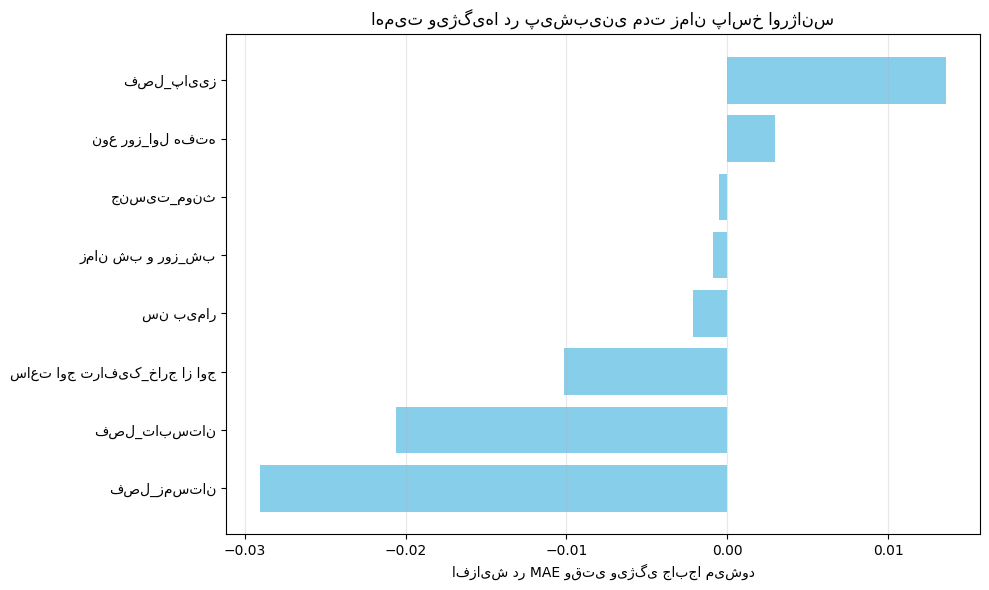

In [ ]:

# اهمیت متغیرها با Permutation Importance (دقیق و قابل اعتماد)

from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

print("محاسبه اهمیت متغیرها...\n")

perm_imp = permutation_importance(
    rf_final, X_test, y_test_time,
    scoring='neg_mean_absolute_error',
    n_repeats=10,
    random_state=42,
    n_jobs=1
)

importance_df = pd.DataFrame({
    'ویژگی': feature_names,
    'اهمیت (افزایش MAE)': -perm_imp.importances_mean
}).sort_values('اهمیت (افزایش MAE)', ascending=False).reset_index(drop=True)

print("اهمیت متغیرها (هرچه عدد بالاتر، ویژگی مهم‌تر است):")
print(importance_df.to_string(index=True))

# نمودار اهمیت
plt.figure(figsize=(10, 6))
plt.barh(importance_df['ویژگی'][::-1], importance_df['اهمیت (افزایش MAE)'][::-1], color='skyblue')
plt.xlabel('افزایش در MAE وقتی ویژگی جابجا می‌شود')
plt.title('اهمیت ویژگی‌ها در پیش‌بینی مدت زمان پاسخ اورژانس')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

محاسبه اهمیت متغیرها برای RandomForestRegressor...

اهمیت ویژگی‌ها (هرچه عدد بالاتر، ویژگی مهم‌تر است):
                         ویژگی  اهمیت (افزایش MAE)
0                   فصل_زمستان            0.029030
1                  فصل_تابستان            0.020601
2  ساعت اوج ترافیک_خارج از اوج            0.010160
3                     سن بیمار            0.002156
4             زمان شب و روز_شب            0.000913
5                   جنسیت_مونث            0.000534
6             نوع روز_اول هفته           -0.002938
7                    فصل_پاییز           -0.013573


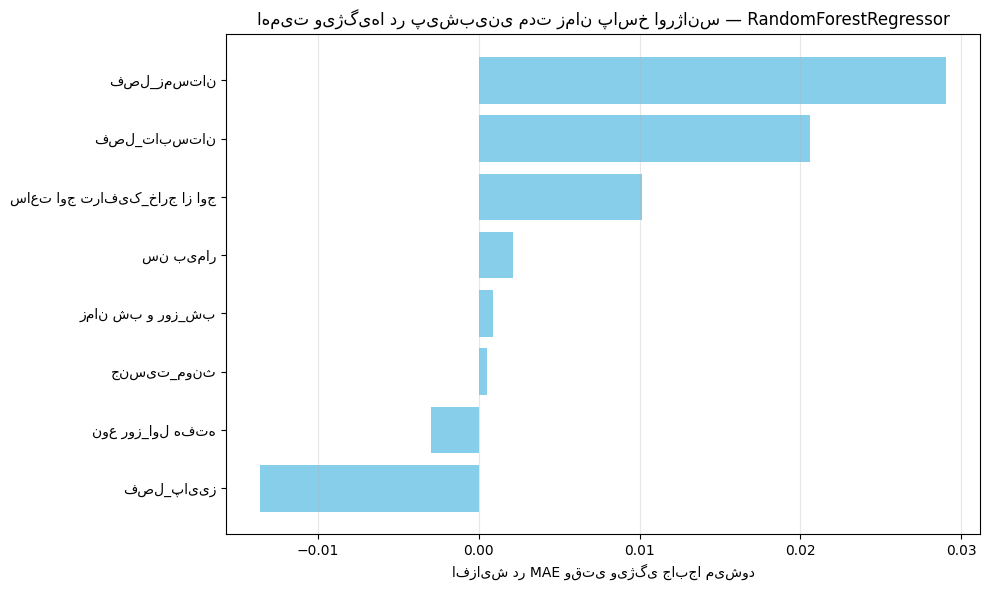

In [ ]:

# اهمیت متغیرها با Permutation Importance — RandomForestRegressor

from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import gc

gc.collect()
print("محاسبه اهمیت متغیرها برای RandomForestRegressor...\n")

# محاسبه permutation importance
# معیار: افزایش MAE هنگام جابجایی ویژگی
perm_imp = permutation_importance(
    rf_final,                # مدل آموزش دیده
    X_test,
    y_test_time,          # هدف: مدت زمان پاسخ
    scoring='neg_mean_absolute_error',
    n_repeats=10,
    random_state=42,
    n_jobs=1
)

#(هرچه افزایش MAE بیشتر، ویژگی مهم‌تر)
importance_df = pd.DataFrame({
    'ویژگی': feature_names,
    'اهمیت (افزایش MAE)': perm_imp.importances_mean
}).sort_values('اهمیت (افزایش MAE)', ascending=False).reset_index(drop=True)

# نمایش جدول
print("اهمیت ویژگی‌ها (هرچه عدد بالاتر، ویژگی مهم‌تر است):")
print(importance_df.to_string(index=True))

# رسم نمودار اهمیت
plt.figure(figsize=(10, 6))
plt.barh(importance_df['ویژگی'][::-1], importance_df['اهمیت (افزایش MAE)'][::-1], color='skyblue')
plt.xlabel('افزایش در MAE وقتی ویژگی جابجا می‌شود')
plt.title('اهمیت ویژگی‌ها در پیش‌بینی مدت زمان پاسخ اورژانس — RandomForestRegressor')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
